R² Score: 0.900
RMSE: 8.06 Mbps


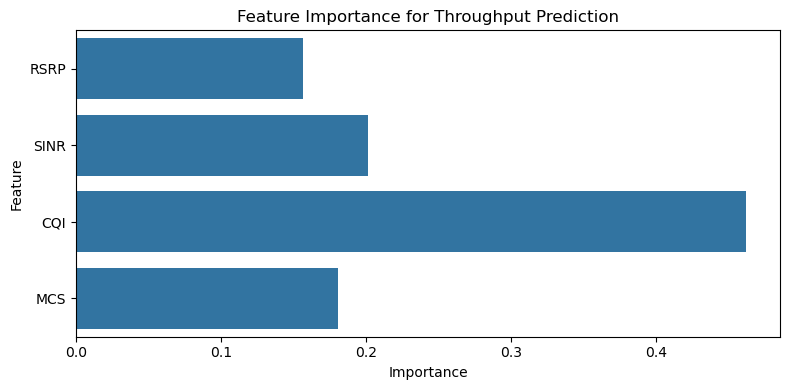

In [2]:


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from math import sqrt

DATA_PATH = "C:/Users/karth/Downloads/Ericsson_Amir/Dryad/"

def load_data(filename):
    df = pd.read_csv(DATA_PATH + filename)
    df["Time and date"] = pd.to_datetime(df["Time and date"], errors="coerce")
    return df

def round_time(df):
    df["Time and date"] = df["Time and date"].dt.round("1s")
    return df

throughput_45 = round_time(load_data('yaw45/input_throughput_with_header.csv'))
LTE_RSRP_45 = round_time(load_data('yaw45/inputf1_rsrp_with_header.csv'))
LTE_SINR_45 = round_time(load_data('yaw45/inputf1_sinr_with_header.csv'))
NR_RSRP_45 = round_time(load_data('yaw45/inputf2_rsrp_with_header.csv'))
NR_SINR_45 = round_time(load_data('yaw45/inputf2_sinr_with_header.csv'))
NR_CQI_45 = round_time(load_data('yaw45/inputf2_cqi_with_header.csv'))
NR_MCS_45 = round_time(load_data('yaw45/inputf2_mcs_with_header.csv'))

for df_tmp in [NR_RSRP_45, NR_SINR_45, NR_CQI_45, NR_MCS_45, LTE_RSRP_45, LTE_SINR_45]:
    df_tmp.drop(columns=["ID", "Latitude", "Longitude", "Altitude"], inplace=True, errors='ignore')


# --- Merge features by rounded time ---
df = throughput_45.copy()
df = df.merge(NR_RSRP_45, on="Time and date", how="inner")
df = df.merge(NR_SINR_45, on="Time and date", how="inner")
df = df.merge(NR_CQI_45, on="Time and date", how="inner")
df = df.merge(NR_MCS_45, on="Time and date", how="inner")

# Rename for clarity if needed
df.rename(columns={
    "DL Throughput Mbps": "Throughput",
    "NR RSRP": "RSRP",
    "NR SINR": "SINR",
    "NR CQI": "CQI",
    "NR MCS": "MCS"
}, inplace=True)

# Drop missing values
df = df.dropna(subset=["Throughput", "RSRP", "SINR", "CQI", "MCS"])

# --- Feature and label setup ---
features = ["RSRP", "SINR", "CQI", "MCS"]
X = df[features]
y = df["Throughput"]

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Evaluation ---
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")

print(f"RMSE: {sqrt(mean_squared_error(y_test, y_pred)):.2f} Mbps")


# --- Feature Importance ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(x=model.feature_importances_, y=features)
plt.title("Feature Importance for Throughput Prediction")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

